# Goal: Monte Carlo Simulation, applied to  Option Pricing

## Hey, Python techies!!

Our BSc course on Financial Data Science is time constrained. There is no time to teach option pricing. Yet, we can take a realistic parametrization of a stock return and simulate it to learn about diffusive risks and jump risks. The latter is also called crash risks or non-Gaussian discretionary moves. 

Prof. Merton, a Nobel Laureate in Economics, and industrial engineer by training, described stock returns to follow a mix of a Gaussian distribution and a Poisson distribution. The Gaussian distribution captures the normal randomness in stock returns. The infrequent, yet, dramatic up and down jumps in stock returns are modelled by a Poisson shock. Prof. Merton derived the price of an option on such a realistic stock return dynamic. That derivation, among other work, was reason to award him with a Nobel Prize in Economics. It also created a new field called "financial engineering". Financial data science benefits from the last thirty years of option pricing. I reveal some of these during an upcoming Masters course on Financial Machine Learning. Yet, for the moment, I want to use Merton's parametrization of stock returns to show you how much you have already learned in this course.


Our battle plan is as follows: First I quickly introduce Merton's Jump-Diffusion Model. Second, we code a function in Python that simulates the Merton’s Stock Price Process. Third, we code a Python function for a payoff of a call and put option. Fourth, we code a Python function that determines the price of that call and put contract. That pricing relies on simulating the density of future stock prices. 

First, I tell you which packages you need

In [8]:
# Import packages for econometric analysis

import numpy as np
import pandas as pd

# Load plotting library

import matplotlib
import matplotlib.pyplot as plt
matplotlib.style.use('ggplot')

#set the seed
np.random.seed(123)

Prof Merton introduced stochastic calculus to financial economics. This follows the tradition of Albert Einstein to model randomness across time by means of an ordinary differential equation plus noise (= stochastic differential equation). An upcoming MSc course on Financial Machine learning offers an introduction to that. For this BSc course, I will do the calculus for you and provide you with the probability density function that Prof. Merton worked with. Intuitively, the density has a diffusive component called $Z_1$ and a jump component called $K$. $Z_1$ follows a standard normal distribution. $K$ follows a Poisson distribution with intensity factor $\lambda$. For a definition of a Possion distribution see https://en.wikipedia.org/wiki/Poisson_distribution. The standard deviation of the diffusive shock is  $\sigma \sqrt{T}$. It is also assumed that once a jump happens, the resulting return is drawn from another Gaussian shock $Z_2$. $Z_2$ is a standard normal shock which is independent of $Z_1$. The standard deviation of the jump shock is termed $b\sqrt{KT}$, where $b$  is the standard deviation of the jump size distribution and $K$ is the random draw of the above mentioned Poisson distriubtion that counts the number of random return jumps per year. 

The resulting description of the continuously compounded stock return for the holding period $0$ to $T$ reads:

\begin{equation}
    \ln \frac{S_T}{S_0} = (r - \lambda a - 0.5 \sigma^2) T + \sigma \sqrt{T} Z_1 + a K T + b \sqrt{K T} Z_2
\end{equation}

where $S_T$ is the price of a stock at time $T$, $r$ is the short-term risk-free rate, $\lambda$ is the expected number of jumps per year, $a$ is the expected return impact of a jump, $0.5 \sigma^2$ is a convexity adjustment (as we work with log returns), $\sigma \sqrt{T} Z_1 \sim N(0, \sigma^2 T)$ is the diffusive return shock, $aKT + b\sqrt{KT} Z_2|_{K} \sim N(aKT, b^2 KT)$, conditional on knowing the realized value of $K$, captures the return innovation due to $K$ realized price jumps between the time points $0$ and $T$. Notice, that $K$ itself is a draw from a Poisson distribution, $K \sim Pois(\lambda)$ where you can treat $\lambda$ as the expected number of jumps per year. 

The stock price is

\begin{equation}
S_T = S_0 \times e^{\ln \frac{S_T}{S_0}}
\end{equation}

which says

\begin{equation}
S_T = S_0 \times e^{ (r - \lambda a - 0.5 \sigma^2) T + \sigma \sqrt{T} Z_1 + a K T + b \sqrt{K T} Z_2   }
\end{equation}

Note: you might have wondered correctly, why there is no risk premium on top of the risk-free rate. That question is spot on. For now, I simply assumed it to be zero. That is not a realistic assumption, yet, for my simulation task it would only affect the expected value of $S_T$. The reason why I assumed it zero here, is that in order to explain it accurately, I would have to teach you the logic behind option pricing, which relies on either hedging arguments or some basic measure theory. I will do so in the MSc course on Financial Machine Learning. For now, simply think about a stock with a zero equity risk premium.

First, we write a Python function that simulates $S_t$ from $t=0$ to $t=T$.  The function is called "simulateJumpDiffusion". The input to the function is
- m: number of paths
- S_0: stock price in $t=0$
- r: short term risk free rate
- lam: $\lambda$, is the expected number of jumps per year (i.e. intensity of Poisson distriubtion)
- sig: standard deviation of diffusive shock
- T: future time point for which we want to know what the stock price will be worth
- a: expected magnitude of a crash induced return
- b: standard deviation of a crash inducued return shock

The output to the function are $m$ draws of future $S_T$'s, where the data generating process for $S_T$ follows the above mentioned Merton Jump Diffusion Model.
 

**Complete the code:**

In [9]:
#set the seed
np.random.seed(123)

def simulateJumpDiffusion(m,S_0,r,lam,sig,T,a,b):
    """
    This function simulates St from t = 0 to t = T with St being the price of a stock at time T

    :param m: number of paths
    :param S_0: stock price in t = 0
    :param r: short term risk free rate
    :param lam: is the expected number of jumps per year
    :param sig: standard deviation of diffusive shock
    :param T: future time point for which we want to know what the stock price will be worth
    :param a: expected magnitude of a crash induced return
    :param b: standard deviation of a crash inducued return shock
    :return: m draws of future where the data generating process follows the above mentioned Merton Jump Diffusion Model.
    """

    # array for storing the solutions
    return_solution = []

    # multiple paths
    for i in range(0,m):

        # note: K P(lam) with size =  None returns 1 value
        K = np.random.poisson(lam)

        # note: being N(0,sig^2T) distributed size = None
        diff_return_shock = np.random.normal(loc = 0,scale = np.sqrt(sig**2 * T))

        # note: being N(aKT,b^2KT) conditional on K distributed
        return_innovation = np.random.normal(loc = (a*K*T),scale = np.sqrt(b**2 * K * T))

        # calculate the stock price in T
        S_t = S_0 * np.exp((r - lam * a - 0.5*sig**2) * T + diff_return_shock + return_innovation)

        return_solution.append(S_t)

    # return the mean of the array for a nice output

    # sol = round(np.mean(return_solution),2)

    # mean
    return return_solution

Second, we assume a more experienced financial data scientist used machine learning tools to learn the parameters of the Jump Diffusion Model. The respective parameters are

r = 0.04, $\lambda = 2$, $\sigma = 0.5$, $a=0.1$, $b=0.2$. Further assume the last observed stock price ($S_0$) was 120 euros. Further assume, you want to simulate the stock price over the next quarter, which means $T=0.25$. Also, assume, you simulate $S_T$ for $m=1000000$ paths.

Some intuition: the risk-free rate is 4\%, there are an expected 2 jumps per year, the annual standard deviation of the diffusive shock is 50\%, the expected jump magnitude (per jump) is 10\% with a standard deviation of 20\%. Note, in the Merton model, jumps can be positive and negative. More recent parameterizations focus on negative jumps in prices and positive jumps in volatility. We analyze this point in the MSc course on Financial Machine Learning.

Some more intuition: You wonder whether it is realistic to expect 2 jumps per year with each coming along with an expected gain of 10\% and a standard deviation of 20\%. Let me tell you that these numbers incorporate investor's priced-in risk premium. It relates to my explanations on the Gordon Growth model, yet, it is slightly more delicate. A precise explanation of that mechanism will be offered in the MSc course on Financial Machine Learning. For now, it suffices to realize that the parameters $\lambda$, $a$, $b$ are adjusted by risk premium (which is the result of investor's risk aversion).

**Complete the code:**

In [10]:
#set the seed
np.random.seed(123)

m = 1000000
S_0 = 120
r =  0.04
lam =  2
sig = 0.5
T =  0.25
a =  0.1
b =  0.2

Third, lets simulate $S_T$ given the above parametrization and save the output in the variable $s_1$. 

**Complete the code:**

In [11]:
#set the seed
np.random.seed(123)

s1 = simulateJumpDiffusion(m= m,S_0 = S_0,r = r,lam = lam,sig = sig,T = T,a = a,b = b)

Fourth, lets double check that the expected stock price in one quarter from now is 122.54 euros, 

$$
E_0[S_T] = 122.54 \, \text{EUR}
$$

**Complete the code:**

In [12]:
#set the seed
np.random.seed(123)

E_s1 = np.mean(s1)
print(E_s1)

122.56095611316744


Fourth, to gain some intuition about jumps in returns, we compare the DGP of Merton to a log-normally distributed stock price. 

A log normally distributed stock price takes the DGP

\begin{equation}
S_T = S_0 \times e^{ (r -  0.5 \sigma^2) T + \sigma \sqrt{T} Z_1}. 
\end{equation}
                    
In that case you have

\begin{equation}
\ln \frac{S_T}{S_0} \sim N( (r - 0.5 \sigma^2 )T, \, \sigma^2 T ).
\end{equation}

Black and Scholes earned themselves a Nobel Prize in Economics for deriving the price of a call and put on a stock that follows a log normal distribution. 

In comparison to the Merton parametrization, the log normal distriubtion is a special case with $\lambda = a = b = 0$.

Fifth, hence, we now re-apply the simulateJumpDiffusion funtion to find the distriubtion of $S_T|\mathcal{F}_0$, assuming the stock price follows a log-normal distribution, and save the output at $s_2$.

**Complete the code:**

In [13]:
#set the seed
np.random.seed(123)

s2 = simulateJumpDiffusion(m= m,S_0 = S_0,r = r,lam = 0,sig = sig,T = T,a = 0,b = 0)

Sixth, we check that the expected stock price under the log-normal model would be

\begin{equation}
E_0[S_T] = 121.18 \; \text{EUR}
\end{equation}

**Complete the code:**

In [14]:
#set the seed
np.random.seed(123)

E_s2 = np.mean(s2)
print(E_s2)

121.17944799063915


Seventh, we now visualize the simulated probability density function of the log-normal and the Merton (log-normal plus jumps) parametrization of stock returns. 

We rely on the histogram function of our plotting library, using 1000 bins, histtype="stepfilled", density=True.

**Complete the code:**

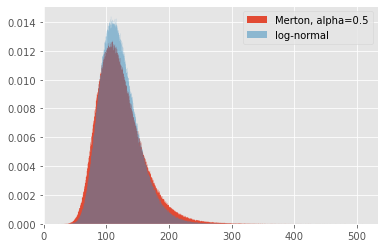

In [33]:
#set the seed
np.random.seed(123)

#plt.figure(1)
plt.hist(x=s1,bins = 1000,histtype="stepfilled",density= True,label = "Merton, alpha=0.5")
plt.hist(x=s2,bins = 1000,histtype="stepfilled",density= True,label = "log-normal", alpha=0.5)
plt.legend(loc='upper right')
plt.show()

Eigth, I now show you how a financial data scientist can estimate the value of options that are written on $S_T$.

In a nutshell, a European call (put) option gives the holder the RIGHT to buy (sell) the underlying stock at time $T$ for a prespecified price $X$. Note, $X$ is called "exercise price" or "strike". Both X and $T$ are set and known at time $t=0$ and kept constant throughout the life of the option. 

Notice, if $S_T > X$, a holder of a call option would exerice the option at $T$ and get the stock for a price of $X$. He could instantly sell it in the market for $S_T$ and pocket the postive gain of $S_T - X$. On the other hand, the holder of the put option would not exercise the put option as he/she could sell the stock for $S_T > X$. 

On the other hand, if $S_T < X$, the holder of a put option would exercise the RIGHT to sell the stock for $X$, while buying it in the (so called) spot market (equity market) for $S_T$. The spread of $X - S_T$ would be the profit at time $T$ for the investor who exercises the put option.

In sum, the payoff at time $T$ of a call option is

\begin{equation}
C_T = max(S_T - X, 0)
\end{equation}

while the payoff at time $T$ of a put option is

\begin{equation}
P_T = max(X-S_T, 0).
\end{equation}

In order to find the price at $t<T$, one applies the net present value logic (as in Gordon Growth model) to get

\begin{equation}
C_t \; \text{and} \; P_t.
\end{equation}

Simplistically speaking, and only for intuition purpose, I am writing it as

\begin{equation}
C_0 = E_0\left[\frac{max(S_T - X, 0)}{(1 + DR_T)^T}\right]
\end{equation}

and

\begin{equation}
P_0 = E_0\left[\frac{max(X - S_T, 0)}{(1 + DR_T)^T}\right].
\end{equation}

A precise derivation of $C_0$ and $P_0$, including all financial economic and financial mathematic insights, will be offered during the MSc course on Financial Machine Learning.

$$
\\
$$

For now, we are going to find $C_0$ and $P_0$ using Monte-Carlo Simulation. The logic is as follows: Above, we have simulated $m$ maths of $S_T|\mathcal{F}_0$. Now, we simply compute the resulting payoff of a call and put option if a particular $S_T$ gets realized. For the discount rate, we discount by the risk-free rate only. Again, a precise explanation of why in that case we only discount by $r$ will be offered in the MSc course on Financial Machine Learning. As we use continuously compounding in the exercise, our discount rate will be

\begin{equation}
(1 + DR_T)^T = exp(r*T)
\end{equation}

Ninth, we now compute the Python function mcCallPrice. It takes as input all possible (based on the simulation) $S_T|\mathcal{F}_0$, the risk-free discount rate $r$, time to maturity of the option contract $T$ and the exercise price of the option, called $X$. The output of the function is $C_0$. Hint: in order to get the expectation, you compute the mean of the payout across all $m$ paths.

**Complete the code:**

In [16]:
#set the seed
np.random.seed(123)

def mcCallPrice(r,T,X,sim_values = None):
    """
    :param r: rsik free rate : skalar
    :param T: time to maturity : skalar
    :param X: strike price : skalar
    :return: price of the option now in t = 0
    """
    #  write solutions of computation
    solution_array = []

    if sim_values is None:
        # get the simulated values
        sim_values = simulateJumpDiffusion(m= m,S_0 = S_0,r = r,lam = lam,sig = sig,T = T,a = a,b = b)

    # discount rate
    discount_rate = np.exp(r*T)

    # for each simulated value:
    for sim_price in sim_values:

        diff = sim_price-X

        # payoff
        payoff = max(diff,0)

        # print((payoff / discount_rate))

        # append the fration theref to the solution array
        solution_array.append((payoff / discount_rate))

    # get the expectation
    C_0 = np.mean(solution_array)

    return C_0


Tenth, we repeat the last step and compute a Python function mcPutPrice.

**Complete the code:**

In [17]:
#set the seed
np.random.seed(123)

def mcPutPrice(r,T,X,sim_values = None):

    """
    :param r: rsik free rate : skalar
    :param T: time to maturity : skalar
    :param X: strike price : skalar
    :param sim_values: arrays with simulated stock prices
    :return: price of the option now in t = 0
    """
    #  write solutions of computation
    solution_array = []

    if sim_values is None:
        # get the simulated values
        sim_values = simulateJumpDiffusion(m= m,S_0 = S_0,r = r,lam = lam,sig = sig,T = T,a = a,b = b)

    # discount rate
    discount_rate = np.exp(r*T)

    # for each simulated value:
    for sim_price in sim_values:

        diff = X-sim_price

        # payoff
        payoff = max(diff,0)

        # append the fration theref to the solution array
        solution_array.append((payoff / discount_rate))

    # get the expectation
    P_0 = np.mean(solution_array)

    return P_0


Eleventh, now we price a so called at-the-money option with maturity $T>0.25yrs$. I define here an at-the-money option as having $X=S_0$.

We compute the $C_0$ and $P_0$ for both, the log-normal and the Merton parametrization for the stock price. The price of the former gets the index 1, the price of the latter gets the index 2.

**Complete the code:**

In [18]:
#set the seed
np.random.seed(123)

X =  S_0
r = r

# the Maturity must be larger then thestock price prediction period
T = 0.28

In [25]:
#set the seed
np.random.seed(123)

c1 = mcCallPrice(r,T,X,s1) #jump diffusion call
c2 = mcCallPrice(r,T,X,s2) #log normal call

In [30]:
#set the seed
np.random.seed(123)

p1  = mcPutPrice(r,T,X,s1) #jump diffusion put
p2  = mcPutPrice(r,T,X,s2) #log normal put

Twelveth, we check that the at-the-money call price  is

\begin{equation}
C_0 = 15.12 \qquad \text{if jumps in returns}
\end{equation}

and 

\begin{equation}
C_0 = 12.47 \qquad  \text{if no jumps in returns}
\end{equation}


In [26]:
#set the seed
np.random.seed(123)

print(c1)

15.104503215269572


In [27]:
#set the seed
np.random.seed(123)

print(c2)

12.44779223912254


Thirteenth, we check that the at-the-money put price is

\begin{equation}
P_0 = 12.61 \qquad \text{if jumps in returns}
\end{equation}

and 

\begin{equation}
P_0 = 11.30 \qquad  \text{if no jumps in returns}
\end{equation}


In [31]:
#set the seed
np.random.seed(123)

print(p1)

12.572069785386754


In [32]:
#set the seed
np.random.seed(123)

print(p2)

11.281480366402297


Fourteenth, note that the spread in call prices is larger than the spread in put prices. The reason for that is visible in the histogram of $S_T|\mathcal{F}_0$. In the current simulation, the jumps create move probability mass on the right part of the tail. Call options benefit from that, which explains why the call price increases over proportionally if returns can jump. Note, this result can change as you change the parametrization. 

As a last learning point, neither the seed nor the number of simulation paths should change the price of calls and puts. If they do, you have not used enough paths in the simulation, hence, increase them.